### Imports

In [101]:
import pandas as pd
import datetime
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.errors import SettingWithCopyWarning
from pandas import to_datetime
import statsmodels.api as sm
from statsmodels import regression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import seaborn as sns

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

### Parameters

In [102]:
run_optimizing = False
google_colab = False

In [103]:
sns.set(style="white")

color = '#1982C4'
color2 = '#FF595E'
color3 = '#8AC926'

### Data loading

In [104]:
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    id = "1PZQLyOiOpKtLt5BVAvWwQEnxZJzvLcD7"
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('Full trading data - All models.csv')  
    total_dataframe_for_analysis = pd.read_csv('Full trading data - All models.csv')
else:
    # Set the path to the root directory
    path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
    # Read dataframes using Dask
    total_dataframe_for_analysis = pd.read_csv(path + '/data/trading/LSTM_MLP_v3.csv')

## Trading behaviour analysis

Create dataframes

In [105]:
# Datetime conversion
total_dataframe_for_analysis['Quote_date'] = pd.to_datetime(total_dataframe_for_analysis['Quote_date'])

# Make data frames with all option_IDs that were ones bought (Position_this_opt > 0) and ones sold (Position_this_opt < 0)
groupes = total_dataframe_for_analysis.groupby('Option_ID')
df_bought = groupes.filter(lambda x: x['Position_this_opt'].sum() > 0)
df_sold = groupes.filter(lambda x: x['Position_this_opt'].sum() < 0)

# Group by option_ID and keep only the ones that were bought and sold
bought_groups = df_bought.groupby('Option_ID')
sold_groups = df_sold.groupby('Option_ID')

# One row per ID
hist_bought = bought_groups.filter(lambda x: x['Position_this_opt'].iloc[0] > 0)
hist_sold = sold_groups.filter(lambda x: x['Position_this_opt'].iloc[0] < 0)

Histogram TTM

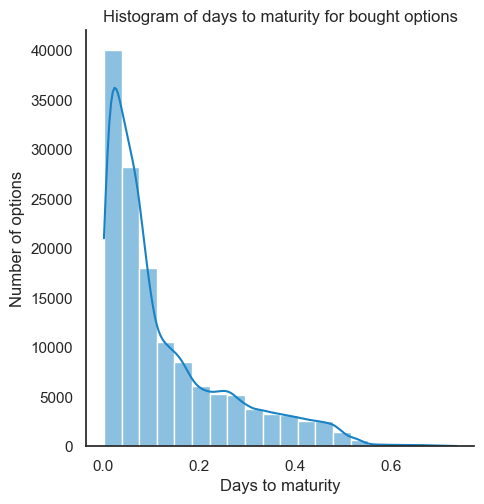

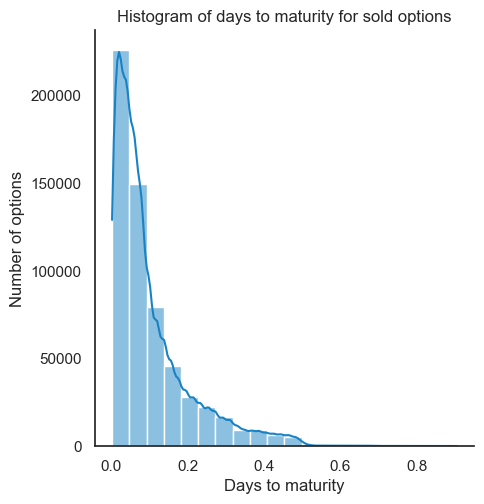

In [106]:
sns.displot(data=hist_bought, x='TTM', bins=20, color=color, kde=True)
# Add title
plt.title('Histogram of days to maturity for bought options')
plt.xlabel('Days to maturity')
plt.ylabel('Number of options')
plt.show()

sns.displot(data=hist_sold, x='TTM', bins=20, color=color, kde=True)
plt.title('Histogram of days to maturity for sold options')
plt.xlabel('Days to maturity')
plt.ylabel('Number of options')
plt.show()


Histogram Moneyness

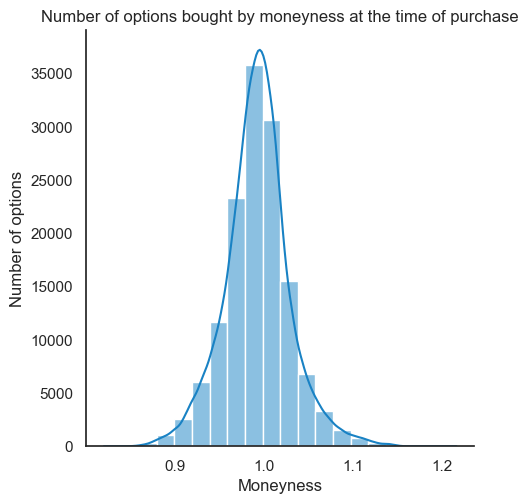

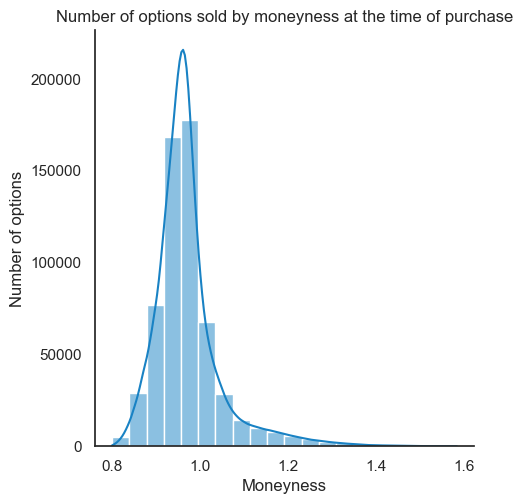

In [107]:
# Calculate Moneyness for options bought and sold
hist_bought["Moneyness"] = hist_bought["Underlying_last"] / hist_bought["Strike"]
hist_bought["Moneyness"] = hist_bought["Moneyness"].round(3)

hist_sold["Moneyness"] = hist_sold["Underlying_last"] / hist_sold["Strike"]
hist_sold["Moneyness"] = hist_sold["Moneyness"].round(3)

# Plot a histogram of the moneyness of the options bought
sns.displot(data=hist_bought, x='Moneyness', bins=20, color=color, kde=True)
plt.title('Number of options bought by moneyness at the time of purchase')
plt.xlabel('Moneyness')
plt.ylabel('Number of options')
plt.show()

# Plot a histogram of the moneyness of the options sold
sns.displot(data=hist_sold, x='Moneyness', bins=20, color=color, kde=True)
plt.title('Number of options sold by moneyness at the time of purchase')
plt.xlabel('Moneyness')
plt.ylabel('Number of options')
plt.show()


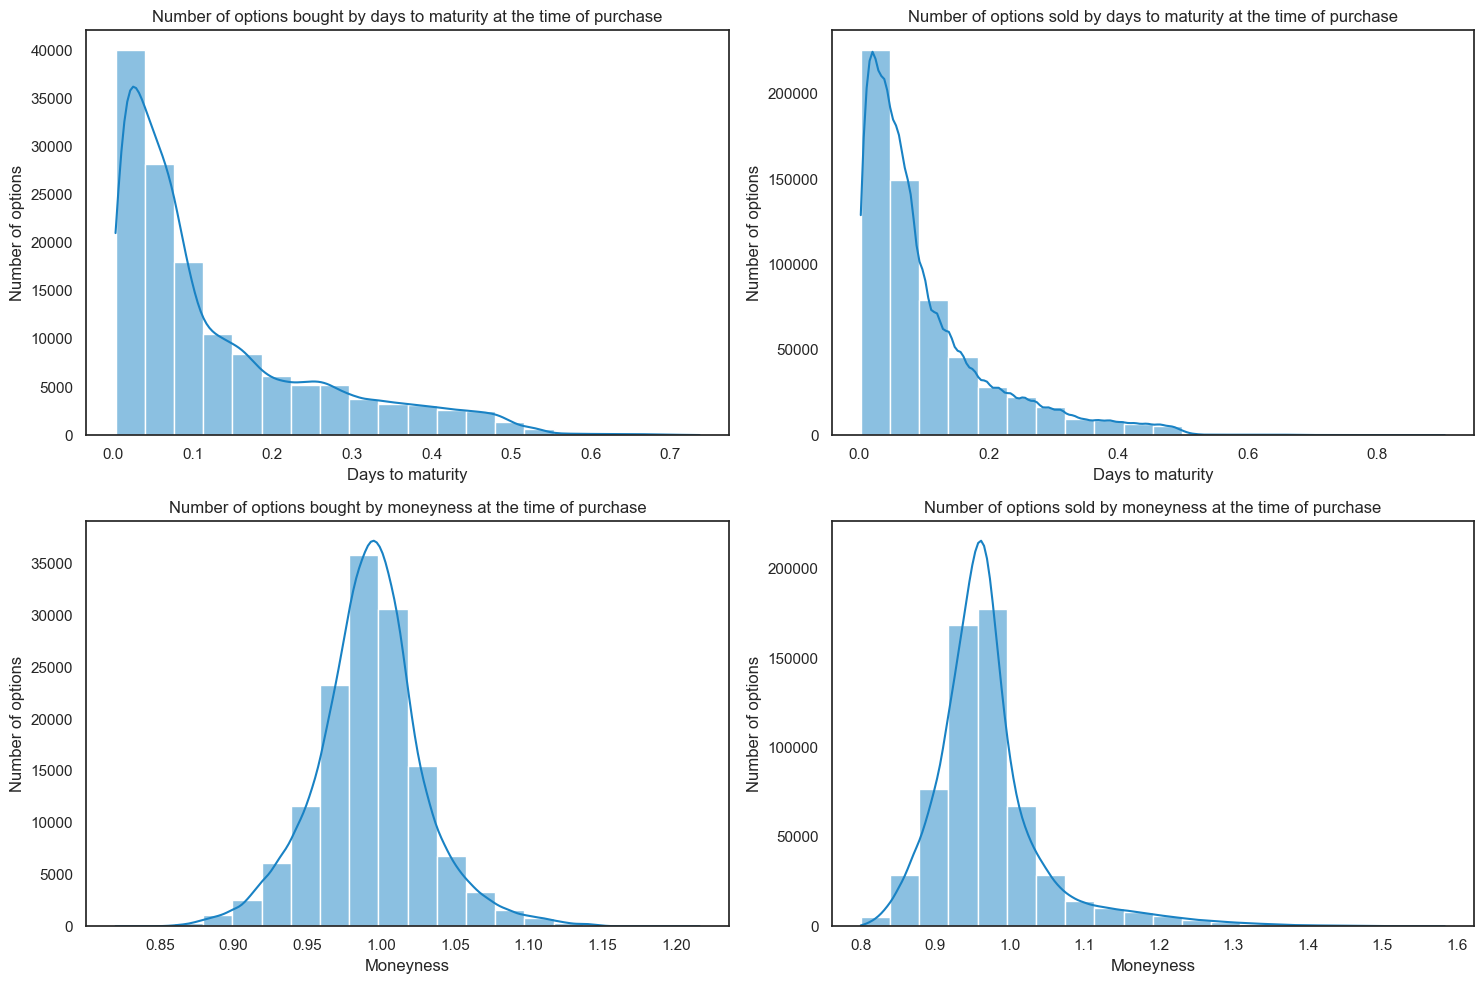

In [108]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(data=hist_bought, x='TTM', bins=20, color=color, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Number of options bought by days to maturity at the time of purchase')
axs[0, 0].set_xlabel('Days to maturity')
axs[0, 0].set_ylabel('Number of options')

sns.histplot(data=hist_sold, x='TTM', bins=20, color=color, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Number of options sold by days to maturity at the time of purchase')
axs[0, 1].set_xlabel('Days to maturity')
axs[0, 1].set_ylabel('Number of options')

sns.histplot(data=hist_bought, x='Moneyness', bins=20, color=color, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Number of options bought by moneyness at the time of purchase')
axs[1, 0].set_xlabel('Moneyness')
axs[1, 0].set_ylabel('Number of options')

sns.histplot(data=hist_sold, x='Moneyness', bins=20, color=color, kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Number of options sold by moneyness at the time of purchase')
axs[1, 1].set_xlabel('Moneyness')
axs[1, 1].set_ylabel('Number of options')

plt.tight_layout()
plt.show()


In [127]:
# Median moneyness of options bought and sold
print('Median moneyness of options bought: ', hist_bought['Moneyness'].median())
print('Median moneyness of options sold: ', hist_sold['Moneyness'].median())
#Standard deviation of moneyness of options bought and sold
print('Standard deviation of moneyness of options bought: ', hist_bought['Moneyness'].std())
print('Standard deviation of moneyness of options sold: ', hist_sold['Moneyness'].std())

Median moneyness of options bought:  0.993
Median moneyness of options sold:  0.96
Standard deviation of moneyness of options bought:  0.03688040381526615
Standard deviation of moneyness of options sold:  0.07689746019391913


In [126]:
print('Mean TTM of options bought: ', hist_bought['TTM'].mean()*365)
print('Mean TTM of options sold: ', hist_sold['TTM'].mean()*365)

Mean TTM of options bought:  47.05063934226813
Mean TTM of options sold:  37.38857410528385


Scatterplot

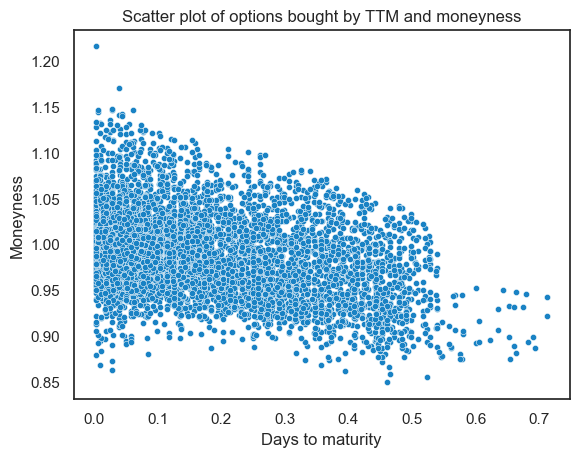

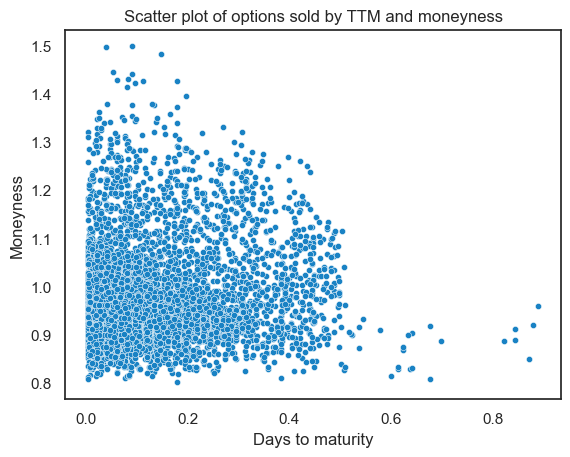

In [109]:
# Sample a subset of options bought and sold
df_year_bought_sample = hist_bought.sample(10000)
df_year_sold_sample = hist_sold.sample(10000)

# Make 2D scatter plot of the options bought by TTM and moneyness
sns.scatterplot(data=df_year_bought_sample, x="TTM", y="Moneyness", color=color, s=20)
plt.title('Scatter plot of options bought by TTM and moneyness')
plt.xlabel('Days to maturity')
plt.ylabel('Moneyness')
plt.show()

# Make 2D scatter plot of the options sold by TTM and moneyness
sns.scatterplot(data=df_year_sold_sample, x="TTM", y="Moneyness", color=color, s=20)
plt.title('Scatter plot of options sold by TTM and moneyness')
plt.xlabel('Days to maturity')
plt.ylabel('Moneyness')
plt.show()


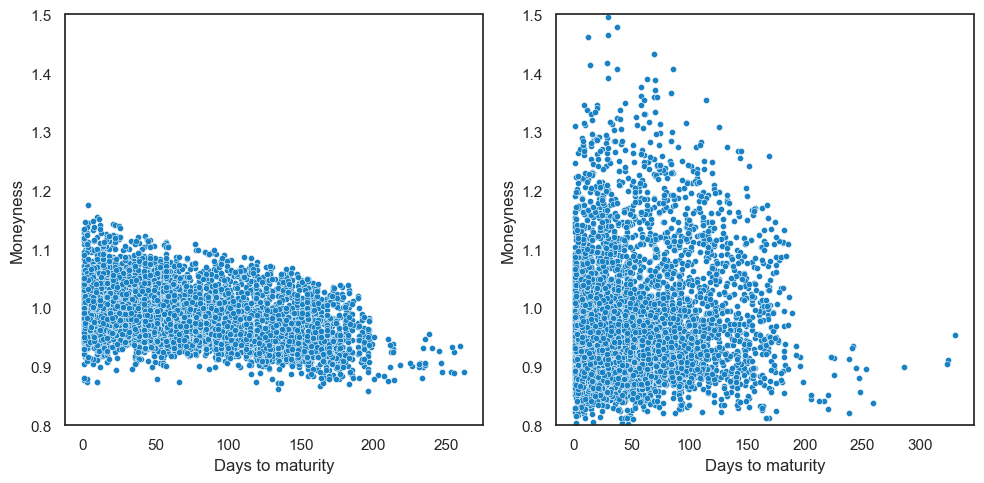

In [124]:
# Sample a subset of options bought and sold
df_year_bought_sample = hist_bought.sample(10000)
df_year_sold_sample = hist_sold.sample(10000)

# Turn TTM into days
df_year_bought_sample['TTM'] = df_year_bought_sample['TTM'] * 365
df_year_sold_sample['TTM'] = df_year_sold_sample['TTM'] * 365

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Set y limits of the left subplot
axs[0].set_ylim(0.8, 1.5)
axs[1].set_ylim(0.8, 1.5)
sns.scatterplot(data=df_year_bought_sample, x="TTM", y="Moneyness", color=color, s=20, ax=axs[0])
axs[0].set_xlabel('Days to maturity')
axs[0].set_ylabel('Moneyness')

sns.scatterplot(data=df_year_sold_sample, x="TTM", y="Moneyness", color=color, s=20, ax=axs[1])
axs[1].set_xlabel('Days to maturity')
axs[1].set_ylabel('Moneyness')


plt.tight_layout()
plt.show()


Development of all options after actually buying

In [111]:
# Get the first bought date for each group
first_bought_date = bought_groups.apply(lambda group: group[group["Position_this_opt"].cumsum() > 0]["Quote_date"].iloc[0])

# Then, for each group, calculate the "Days after buy"
bought_groups_with_days = []
for option_id, group in bought_groups:
    group = group[group["Position_this_opt"].cumsum() > 0]
    first_date = first_bought_date[option_id]
    group.loc[group.index, "Days after buy"] = (group["Quote_date"] - first_date).dt.days
    bought_groups_with_days.append(group)
bought_groups_with_days = pd.concat(bought_groups_with_days)


# Repeat similar steps for sold groups
first_sold_date = sold_groups.apply(lambda group: group[group["Position_this_opt"].cumsum() < 0]["Quote_date"].iloc[0])

sold_groups_with_days = []
for option_id, group in sold_groups:
    group = group[group["Position_this_opt"].cumsum() < 0]
    first_date = first_sold_date[option_id]
    group.loc[group.index, "Days after sell"] = (group["Quote_date"] - first_date).dt.days
    sold_groups_with_days.append(group)
sold_groups_with_days = pd.concat(sold_groups_with_days)

# Group by "Days after buy" / "Days after sell" and take the mean of the price for each day
bought_groups_with_days = bought_groups_with_days.groupby("Days after buy")["Price"].mean().reset_index()
sold_groups_with_days = sold_groups_with_days.groupby("Days after sell")["Price"].mean().reset_index()

# Apply gaussian filter
simga = 1.2
bought_groups_with_days["Price"] = gaussian_filter1d(bought_groups_with_days["Price"], simga)
sold_groups_with_days["Price"] = gaussian_filter1d(sold_groups_with_days["Price"], simga)

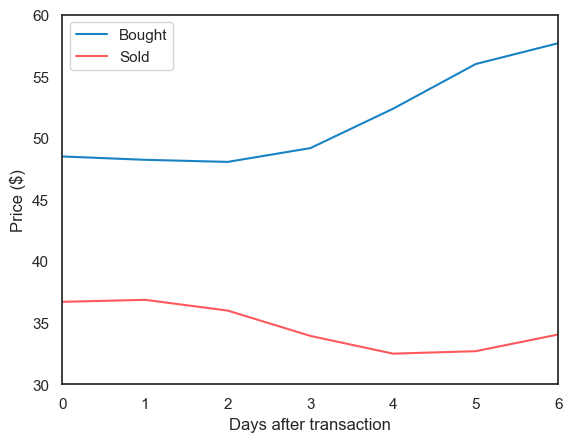

In [112]:
# Plot the price of the options bought as a function of the days after buy
sns.lineplot(data=bought_groups_with_days, x="Days after buy", y="Price", color=color, label="Bought")
sns.lineplot(data=sold_groups_with_days, x="Days after sell", y="Price", color=color2, label="Sold")
plt.xlabel('Days after transaction')
plt.xlim(0, 6)
plt.ylim(30,60)
plt.ylabel('Price ($)')
plt.show()

Development after first signal

In [113]:
# Make data frames with all option_IDs that were ones bought (Position_this_opt > 0) and ones sold (Position_this_opt < 0)
groupes = total_dataframe_for_analysis.groupby('Option_ID')
df_buy = groupes.filter(lambda x: x['Signal'].sum() > 0)
df_sell = groupes.filter(lambda x: x['Signal'].sum() < 0)

# Group by option_ID and keep only the ones that were bought and sold
buy_groups = df_buy.groupby('Option_ID')
sell_groups = df_sell.groupby('Option_ID')

# First buy/sell singal
first_buy_date = buy_groups.apply(lambda group: group[group["Signal"].cumsum() > 0]["Quote_date"].iloc[0])
first_sell_date = sell_groups.apply(lambda group: group[group["Signal"].cumsum() < 0]["Quote_date"].iloc[0])

# Then, for each group, calculate the "Days after buy"
buy_groups_with_days = []
for option_id, group in buy_groups:
    group = group[group["Signal"].cumsum() > 0]
    first_date = first_buy_date[option_id]
    group.loc[group.index, "Days after buy"] = (group["Quote_date"] - first_date).dt.days
    buy_groups_with_days.append(group)
buy_groups_with_days = pd.concat(buy_groups_with_days)

# Repeat similar steps for sold groups
sell_groups_with_days = []
for option_id, group in sell_groups:
    group = group[group["Signal"].cumsum() < 0]
    first_date = first_sell_date[option_id]
    group.loc[group.index, "Days after sell"] = (group["Quote_date"] - first_date).dt.days
    sell_groups_with_days.append(group)
sell_groups_with_days = pd.concat(sell_groups_with_days)

# Group by "Days after buy" / "Days after sell" and take the mean of the price for each day
buy_groups_with_days = buy_groups_with_days.groupby("Days after buy")["Price"].mean().reset_index()
sell_groups_with_days = sell_groups_with_days.groupby("Days after sell")["Price"].mean().reset_index()

# Apply gaussian filter
simga = 1.2
buy_groups_with_days["Price"] = gaussian_filter1d(buy_groups_with_days["Price"], simga)
sell_groups_with_days["Price"] = gaussian_filter1d(sell_groups_with_days["Price"], simga)

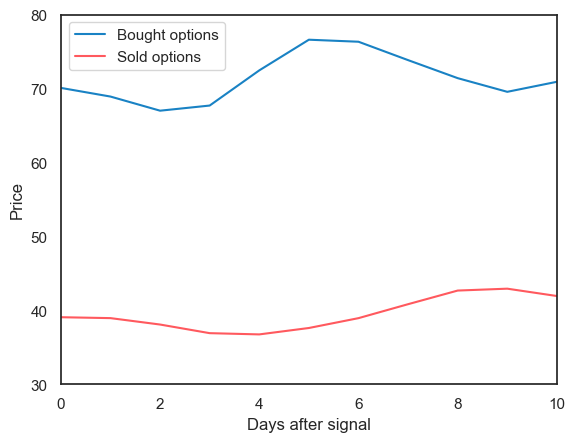

In [114]:
# Plot the price of the options bought as a function of the days after buy
sns.lineplot(x="Days after buy", y="Price", data=buy_groups_with_days, color=color, label="Bought options")

# Plot the price of the options sold as a function of the days after sell
sns.lineplot(x="Days after sell", y="Price", data=sell_groups_with_days, color=color2, label="Sold options")

plt.xlabel('Days after signal')
plt.xlim(0, 10)
plt.ylim(30, 80)
plt.ylabel('Price')
plt.legend()
plt.show()

In [115]:
df_holding_buy = total_dataframe_for_analysis[total_dataframe_for_analysis["Position_this_opt"] > 0]
df_holding_sell = total_dataframe_for_analysis[total_dataframe_for_analysis["Position_this_opt"] < 0]

# Get new dataframe with number of rows for each option_ID
df_holding_buy = df_holding_buy.groupby('Option_ID').size().reset_index(name='counts')
df_holding_sell = df_holding_sell.groupby('Option_ID').size().reset_index(name='counts')

display("Average holding period for options bought: ", df_holding_buy["counts"].mean())
display("Average holding period for options sold: ", df_holding_sell["counts"].mean())
display("Median holding period for options bought: ", df_holding_buy["counts"].median())
display("Median holding period for options sold: ", df_holding_sell["counts"].median())

'Average holding period for options bought: '

12.92808432927252

'Average holding period for options sold: '

23.52832359550562

'Median holding period for options bought: '

6.0

'Median holding period for options sold: '

17.0

Overall plot

In [116]:
def plot(df):
    # Just keep one row per Quote_date, and that should be the last row
    df = df.groupby('Quote_date').last()

    # Plot 'Balance' over time
    sns.lineplot(data=df, x=df.index, y='Balance', color=color2, label='Cash')

    # Plot 'Total value' over time
    sns.lineplot(data=df, x=df.index, y='Total_value', color=color, label='Total value')

    # Plot 'Options_value' over time
    sns.lineplot(data=df, x=df.index, y='Options_value', color=color3, label='Net value of options')

    plt.xticks(rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Value ($)')
    plt.legend()
    plt.show()

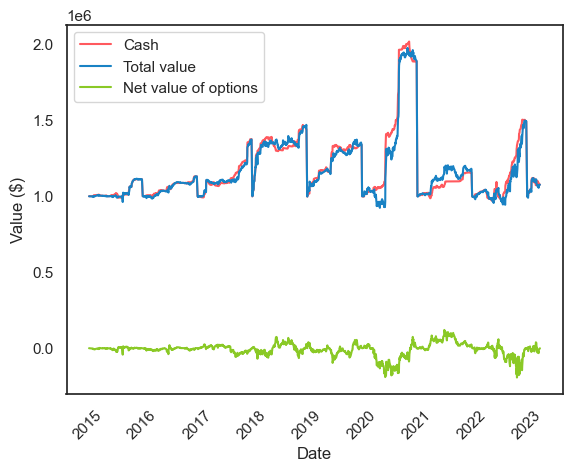

In [117]:
if run_optimizing == False:
    plot(total_dataframe_for_analysis)

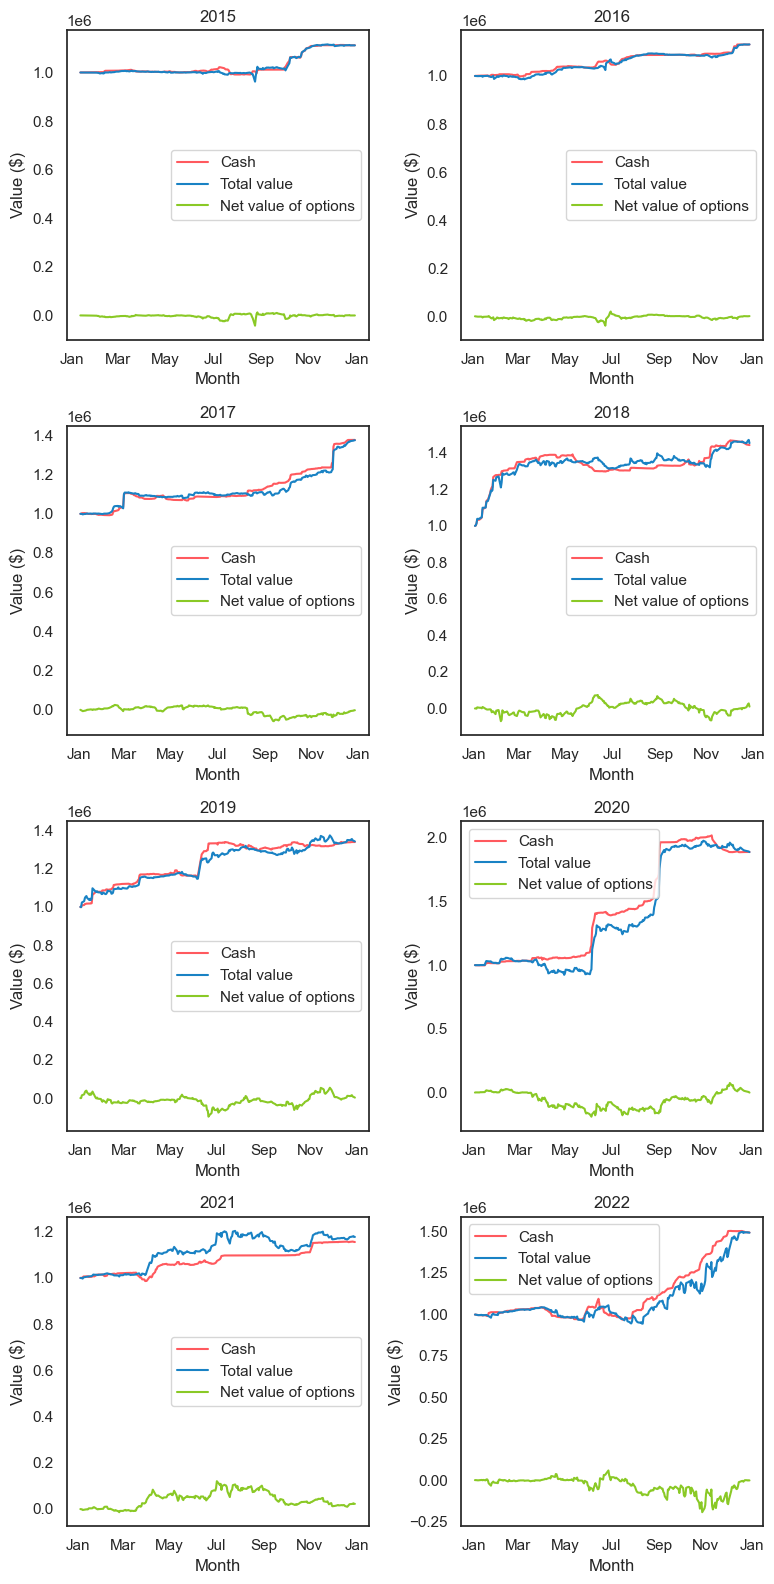

In [118]:
import matplotlib.dates as mdates

fig, axs = plt.subplots(4, 2, figsize=(8, 16)) # Adjust figure size according to your needs

def plot(df, ax, title):
    # Just keep one row per Quote_date, and that should be the last row
    df = df.groupby('Quote_date').last()

    # Plot 'Balance' over time
    sns.lineplot(data=df, x=df.index, y='Balance', color=color2, label='Cash', ax=ax, linewidth=1.5)

    # Plot 'Total value' over time
    sns.lineplot(data=df, x=df.index, y='Total_value', color=color, label='Total value', ax=ax, linewidth=1.5)

    # Plot 'Options_value' over time
    sns.lineplot(data=df, x=df.index, y='Options_value', color=color3, label='Net value of options', ax=ax, linewidth=1.5)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Change date format to three-letter month name
    ax.set_xlabel('Month')
    ax.set_ylabel('Value ($)')
    ax.legend()
    ax.set_title(title)  # Added this line

# Adjust this if you have more years or different range
years = list(range(2015, 2023))

for i, year in enumerate(years):
    df = total_dataframe_for_analysis[total_dataframe_for_analysis["Quote_date"].dt.year == year]
    plot(df, axs[i//2, i%2], f'{year}')  # Adjusted this line

plt.tight_layout()
plt.show()


## Delta analysis

In [119]:
df = total_dataframe_for_analysis.copy()

In [120]:
df['Options_value'] = 0
for date in df['Quote_date'].unique():
    # Net value
    options_value_sum = (df.loc[df['Quote_date'] == date, 'Position_this_opt'] * df.loc[df['Quote_date'] == date, 'Price']).sum()
    df.loc[df['Quote_date'] == date, 'Options_value'] = options_value_sum
    # Absolute value
    long_options_value_sum = (df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] > 0), 'Position_this_opt'] * df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] > 0), 'Price']).sum()
    short_options_value_sum = (df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] < 0), 'Position_this_opt'] * df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] < 0), 'Price']).sum()
    df.loc[df['Quote_date'] == date, 'Long_options_value'] = long_options_value_sum
    df.loc[df['Quote_date'] == date, 'Short_options_value'] = short_options_value_sum

    # Average delta value of all options combined
    # (position * price * delta) / (position * price)
    long_options_delta_sum = (df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] > 0), 'Position_this_opt'] * df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] > 0), 'Price'] * df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] > 0), 'Delta']).sum()
    short_options_delta_sum = (df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] < 0), 'Position_this_opt'] * df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] < 0), 'Price'] * df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] < 0), 'Delta']).sum()        
    if long_options_value_sum + short_options_value_sum == 0:
        average_delta = 0
    else:
        average_delta = (long_options_delta_sum + short_options_delta_sum) / (abs(long_options_value_sum) + abs(short_options_value_sum))

    df.loc[df['Quote_date'] == date, 'Average_delta'] = average_delta
df['Total_value'] = df['Balance'] + df['Options_value']

In [121]:
df['Average_delta_smooth'] = gaussian_filter1d(df['Average_delta'], sigma=300)

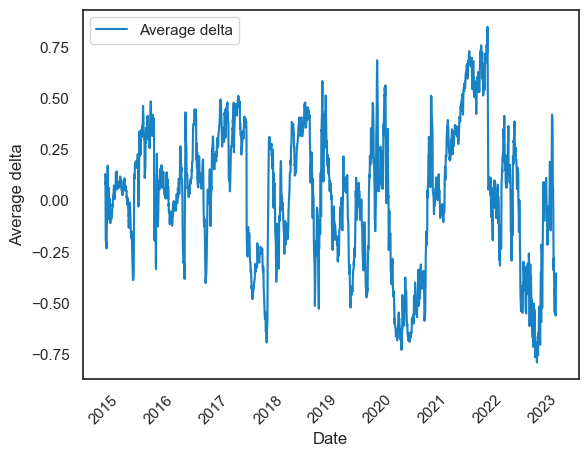

In [122]:
# Plot average delta over time
sns.lineplot(data=df, x="Quote_date", y='Average_delta_smooth', color=color, label='Average delta')

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Average delta')
plt.legend()
plt.show()